In [1]:
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import json
import networkx as nx
import pandas as pd
from ast import literal_eval
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt


In [2]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [3]:
G_week4 = read_json_file('./data/graph.json')

In [4]:
field_list = []

def remove_node_if_no_field(author):
    try:
        field = G_week4.nodes[author]['top_field']
        if field == 'nan':
            G_week4.remove_node(author)
        elif str(field) == 'nan':
            G_week4.remove_node(author)
        else:
            field_list.append(field)
    except KeyError:
        G_week4.remove_node(author)

authors = list(G_week4.nodes)
for a in authors:
    remove_node_if_no_field(a)

In [5]:
n = len(G_week4.nodes)
print(n)

5640


In [6]:
print(G_week4.nodes[83401236]['top_field'])
print(list(G_week4.adj[83401236]))

Geography
[]


In [7]:
def edge_same_top_field(edge, graph):
    field_a = graph.nodes[edge[0]]['top_field']
    field_b = graph.nodes[edge[1]]['top_field']
    return field_a == field_b



In [8]:
top_field_fraq_list = [edge_same_top_field(edge, G_week4) for edge in list(G_week4.edges)]

In [9]:
top_field_fraq = np.mean(top_field_fraq_list)

In [10]:
def randomize_field_get_mean(graph):
    for author, field in zip(list(graph.nodes), np.random.permutation(field_list)):
        graph.nodes[author]['top_field'] = field

    top_field_fraq = [edge_same_top_field(edge, graph) for edge in list(graph.edges)]

    return np.mean(top_field_fraq)

results = []
N_repeat = 500
graph_copy = G_week4.copy()

for i in tqdm(range(N_repeat)):
    results.append(randomize_field_get_mean(graph_copy))

100%|██████████| 500/500 [00:10<00:00, 48.96it/s]


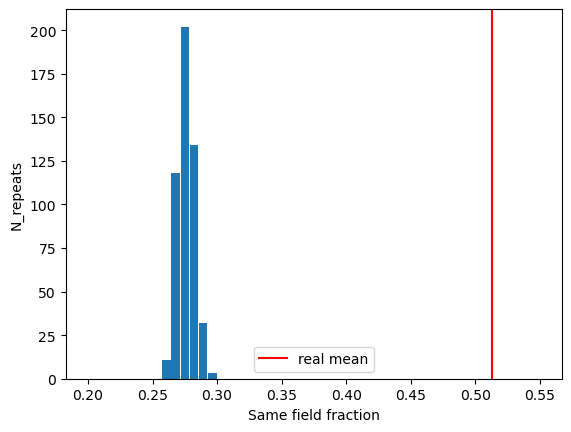

In [11]:
bins = np.linspace(0.2, 0.55, 50)
hist, edges = np.histogram(results, bins=bins)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, axs = plt.subplots()
axs.bar(x, hist, width=width*0.9)

axs.set_xlabel('Same field fraction')
axs.set_ylabel('N_repeats')
axs.axline((top_field_fraq, 0), (top_field_fraq, max(results)), color='red', label='real mean')
axs.legend()

In [12]:
fields_unique = np.unique(field_list)
fields_unique_n = len(fields_unique)

field_index = {}

for i in range(fields_unique_n): # Use this index for matrix
    field_index[fields_unique[i]] = i

degree_max = np.max([t[1] for t in list(G_week4.degree)])
print(degree_max)

field_matrix = np.zeros((fields_unique_n-1, fields_unique_n-1)) # -1 to avoid the nan which is included in fields unique
degree_matrix = np.zeros((44, 44))

for edge in list(G_week4.edges): # For all edges, increment related matrix values

    field_a = G_week4.nodes[edge[0]]['top_field']
    field_b = G_week4.nodes[edge[1]]['top_field']

    deg_a = G_week4.degree[edge[0]]
    deg_b = G_week4.degree[edge[1]]

    degree_matrix[deg_a, deg_b] += 1
    degree_matrix[deg_b, deg_a] += 1

    try:
        field_a_index = field_index[field_a]
        field_b_index = field_index[field_b]

        field_matrix[field_a_index, field_b_index] += 1
        field_matrix[field_b_index, field_a_index] += 1

    except: # Some fields are nan, do nothing
        pass

field_matrix = field_matrix.astype(int)
field_matrix = np.divide(field_matrix, np.sum(field_matrix))

degree_matrix = np.divide(degree_matrix, np.sum(degree_matrix))



43


In [13]:
r_field = (np.trace(field_matrix) - np.sum(field_matrix**2))/(1-np.sum(field_matrix**2))
r_degree = (np.trace(degree_matrix) - np.sum(degree_matrix**2))/(1-np.sum(degree_matrix**2))

In [14]:
print("assortativity coefficient for field", r_field)

print("assortativity coefficient for degree", r_degree)

print(G_week4.degree[83401236])


assortativity coefficient for field 0.4547015459566509
assortativity coefficient for degree 0.4724491513780552
0


In [15]:
print(fields_unique)
print((field_matrix*100).astype(int))

['Art' 'Biology' 'Business' 'Chemistry' 'Computer Science' 'Economics'
 'Engineering' 'Environmental Science' 'Geography' 'Geology' 'History'
 'Materials Science' 'Mathematics' 'Medicine' 'Philosophy' 'Physics'
 'Political Science' 'Psychology' 'Sociology']
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 38  1  0  0  0  0  0  0  0  4  0  1  2  1]
 [ 0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 

In [16]:
from netwulf.interactive import visualize

**Exercise 2**

In [17]:
G_karate = nx.karate_club_graph()

In [18]:
club_colors = {'Mr. Hi': '#0000ff', 'Officer': '#ff0000'}

for i in range(len(G_karate.nodes)):
    club = G_karate.nodes[i]['club']
    G_karate.nodes[i]['color'] = club_colors[club]

def modularity(graph, partitioning):
    L_c = defaultdict(lambda: 0)
    L = len(graph.edges)
    k_c = defaultdict(lambda: 0)


    for node in graph.nodes:

        partition = graph.nodes[node][partitioning]
        deg = len(graph.adj[node])
        k_c[partition] += deg

    k = len(graph.edges)

    for edge in graph.edges:
        partition1 = graph.nodes[edge[0]][partitioning]
        partition2 = graph.nodes[edge[1]][partitioning]
        if partition1 == partition2:
            L_c[partition1] += 1

    M = 0

    partitions = list(L_c.keys())

    #print(k_c)
    #print(L_c)

    for key in partitions:
        #print("Community", key)
        #print("L_c", L_c[key], L, "K_c", k_c[key])
        M += (L_c[key]/L) - (k_c[key]/(2*L))**2

    return M





# 3

Modularity reflects communities within the network structure. A high modularity means a partition is good at separating chunks of nodes that have high interlinkage. This also means that if a network structure is scrambled, the modularity can be greatly affected using the same partition.

Another way of looking at it, is that modularity is high, when few links (edges) need to be broken to create to separate graphs for each partition.

In [19]:
# 1

#visualize(G)


In [20]:
# 4
modularity_karate_club = modularity(G_karate, 'club')
print(modularity_karate_club)

0.3582347140039447


In [44]:
# 5
rng = np.random.default_rng()

def get_two_edges(graph):
    n_edges = len(graph.edges)
    n = np.random.choice(n_edges, size=2, replace=False)
    edge1 = list(graph.edges)[n[0]]
    edge2 = list(graph.edges)[n[1]]
    return edge1, edge2

def double_edge_swap(graph):
    (u, v), (x, y) = get_two_edges(graph)

    if u == v or v == x:
        return double_edge_swap(graph)

    if graph.has_edge(u, y):
        return double_edge_swap(graph)

    if graph.has_edge(x, v):
        return double_edge_swap(graph)

    graph.remove_edge(u, v)
    graph.remove_edge(x, y)

    graph.add_edge(u, y, weight=1)
    graph.add_edge(x, v, weight=1)

    return graph

def N_swaps(graph, N = 100):
    if N > 0:
        return N_swaps(double_edge_swap(graph), N=N-1)
    else:
        return graph

G_copy = G_karate.copy()
n_edges = len(G_copy.edges)
G_copy = N_swaps(G_copy, n_edges*2+1) # Perform N * 2 swaps where N is amount of edges


In [47]:
# 6
adj_check = []

for node in G_karate.nodes:
    deg_1 = G_karate.adj[node]
    deg_2 = G_copy.adj[node]

    adj_check.append(len(deg_1) == len(deg_2))

print("Are all degrees the same?")
print(all(adj_check))


Are all degrees the same?
True


In [52]:
# Modularity debug
test_graph = G_karate.copy()
test_graph = N_swaps(test_graph, N=200)
val = modularity(test_graph, 'club')
print(val)


-0.18022682445759375


In [24]:
#visualize(test_graph)

# Ex2 7

In [25]:
# 7
modularity_res = []
n_edges = len(G_karate.edges)

PARTITION = 'club'

for i in tqdm(range(1000)):
    graph = N_swaps(G_karate.copy(), N=n_edges * 2)
    val = modularity(graph, PARTITION)
    modularity_res.append(val)

100%|██████████| 1000/1000 [00:37<00:00, 26.36it/s]


# Ex2 8

In [26]:
# 8
modularity_average = np.mean(modularity_res)
modularity_std = np.std(modularity_res)

print("Average", modularity_average, "Std", modularity_std)

Average -0.15371157955292575 Std 0.043644132337500044


# Ex2 9

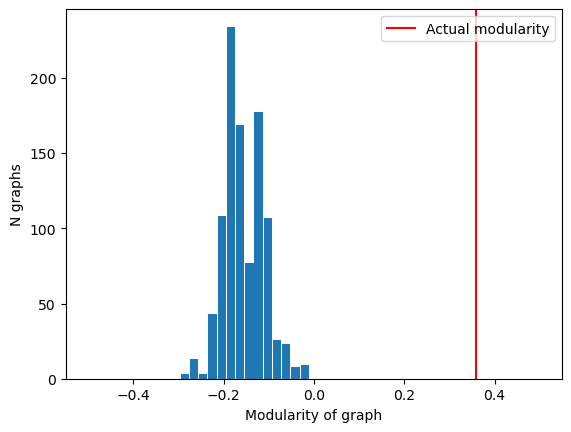

In [27]:
# 9
bins = np.linspace(-0.5, 0.5, 50)
hist, edges = np.histogram(modularity_res, bins=bins)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, axs = plt.subplots()
axs.bar(x, hist, width=width*0.9)

axs.set_xlabel('Modularity of graph')
axs.set_ylabel('N graphs')
axs.axvline(x=modularity_karate_club, color='red', label='Actual modularity')
axs.legend()


# Ex2 10

The club split is a good partitioning because the modularity is much higher without randomization.

Randomizing the solely edges, keeping same degree of nodes, make sure we stay true to the graph. The total degree of nodes is a measure in the modularity calculation, so it is good to avoid changing this about the model.

The value from modularity can be hard to interpret because it is just a number. Using randomization to get a pool of different models enabled us to use statistics, which is a much safer way of deriving conclusions as simple as: "from visual assessment, the original modularity is almost certainly not random chance" and since it is so far from the distribution in the graph, we can safely assume that this is statistically significant, just from looking at it.

# Ex2 11

In [28]:
import community
partition = community.best_partition(G_karate)
print(partition)

G_community = G_karate.copy()

for node in G_community.nodes:
    G_community.nodes[node]['club'] = partition[node]


{0: 0, 1: 0, 2: 0, 3: 0, 4: 2, 5: 2, 6: 2, 7: 0, 8: 1, 9: 1, 10: 2, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 2, 17: 0, 18: 1, 19: 0, 20: 1, 21: 0, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1}


In [29]:
print("Louvain algorithm graph modularity:", modularity(G_community, 'club'))
print("Original karate club graph modularity:", modularity_karate_club)

Louvain algorithm graph modularity: 0.39907955292570685
Original karate club graph modularity: 0.3582347140039447


### Ex2 11 Text

The new club split achieves a higher modularity, revealing that a higher modularity is possible when increasing the amount of clubs.

# Ex2 12

In [30]:
A = len(np.unique(list(partition.values())))

D = np.zeros((2, A))

for node in G_karate.nodes:
    c = partition[node]
    group_split = 0 if G_karate.nodes[node]['club'] == 'Mr. Hi' else 1
    D[group_split, c] += 1

print(D)



[[11.  1.  5.]
 [ 0. 17.  0.]]


### Ex2 12 Text

We see that community 1 and 2 only has items from group split 1 (Mr. Hi).

Community 3 is special because it has nodes in common with both group splits.

Community 4 has nodes from only split 2 (Officer).

# Exercise 3

In [31]:
G_week4_partition = community.best_partition(G_week4)


N_communities = len(np.unique(list(G_week4_partition.values())))

unique, counts = np.unique(list(G_week4_partition.values()), return_counts=True)


In [59]:
with open("data/author_graph_partition_dict.json", "w") as write_file:
    json.dump(G_week4_partition, write_file, indent=4)

Number of communities: 1425
Counts of community sizes:


Text(0.5, 1.0, 'Histogram of the amount of nodes in each community')

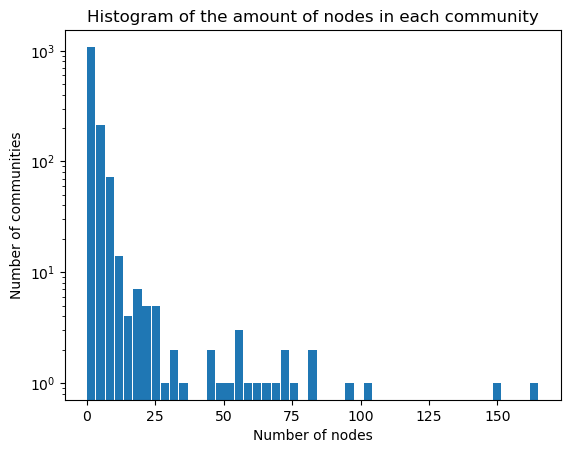

In [32]:
print("Number of communities:", N_communities)
print("Counts of community sizes:")

bins = np.linspace(0, max(counts), 50)
hist, edges = np.histogram(counts, bins=bins)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]

fig, axs = plt.subplots()
axs.bar(x, hist, width=width*0.9)

axs.set_xlabel('Number of nodes')
axs.set_ylabel('Number of communities')
axs.set_yscale('log')
axs.set_title('Histogram of the amount of nodes in each community')


In [33]:
G_week4_copy = G_week4.copy()

for node in G_week4_copy.nodes:
    G_week4_copy.nodes[node]['community'] = G_week4_partition[node]

G_week4_modularity = modularity(G_week4_copy, 'community')


{0: 29, 1: 2, 2: 103, 3: 74, 4: 4, 5: 165, 6: 3, 7: 63, 8: 5, 9: 6, 10: 151, 11: 1, 12: 9, 13: 2, 14: 68, 15: 1, 16: 1, 17: 4, 18: 6, 19: 59, 20: 8, 21: 1, 22: 3, 23: 6, 24: 2, 25: 25, 26: 6, 27: 50, 28: 2, 29: 51, 30: 2, 31: 5, 32: 95, 33: 12, 34: 6, 35: 64, 36: 19, 37: 5, 38: 84, 39: 4, 40: 2, 41: 19, 42: 3, 43: 1, 44: 1, 45: 1, 46: 1, 47: 5, 48: 7, 49: 44, 50: 5, 51: 1, 52: 3, 53: 5, 54: 5, 55: 3, 56: 7, 57: 1, 58: 77, 59: 71, 60: 2, 61: 8, 62: 4, 63: 12, 64: 46, 65: 2, 66: 54, 67: 2, 68: 8, 69: 25, 70: 1, 71: 1, 72: 2, 73: 1, 74: 2, 75: 1, 76: 1, 77: 1, 78: 1, 79: 8, 80: 3, 81: 5, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 4, 88: 2, 89: 8, 90: 1, 91: 10, 92: 2, 93: 3, 94: 2, 95: 5, 96: 2, 97: 2, 98: 1, 99: 34, 100: 23, 101: 11, 102: 4, 103: 3, 104: 6, 105: 2, 106: 2, 107: 1, 108: 3, 109: 9, 110: 3, 111: 5, 112: 1, 113: 1, 114: 6, 115: 2, 116: 3, 117: 5, 118: 2, 119: 2, 120: 1, 121: 1, 122: 8, 123: 4, 124: 1, 125: 3, 126: 5, 127: 3, 128: 2, 129: 10, 130: 1, 131: 6, 132: 2, 133: 5, 134: 

In [35]:
print("Author graph from week 4 modularity:", G_week4_modularity)

Author graph from week 4 modularity: 0.9791866459374632


In [36]:
partition_count_sorted = sorted(dict(zip(unique, counts)).items(), key=lambda x: x[1], reverse=True)

N = 10
top_N_partitions = partition_count_sorted[:N]
# print(top_N_partitions)

DEFAULT_COLOR = '#8c8c8c'

partition_colors = defaultdict(lambda: DEFAULT_COLOR)

nice_colors = ['#0fdbff', '#0fdbff', '#ff0fb3', '#5e3582', '#ffe70f', '#1e9648', '#1e6296', '#4a1e96', '#961e6a', '#51888c']


for i in range(N):
    partition = top_N_partitions[i][0]
    partition_colors[partition] = nice_colors[i]

# print(partition_colors)

[(5, 165), (10, 151), (2, 103), (32, 95), (38, 84), (221, 83), (58, 77), (3, 74), (59, 71), (14, 68)]
defaultdict(<function <lambda> at 0x7fbae0737b50>, {5: '#0fdbff', 10: '#0fdbff', 2: '#ff0fb3', 32: '#5e3582', 38: '#ffe70f', 221: '#1e9648', 58: '#1e6296', 3: '#4a1e96', 59: '#961e6a', 14: '#51888c'})


In [37]:
for node in G_week4_copy.nodes:
    G_week4_copy.nodes[node]['color'] = partition_colors[G_week4_partition[node]]

# print(len(G_week4_copy.nodes))

5640


In [56]:
GraphCopy = G_week4_copy.copy()

Allnodes = list(GraphCopy.nodes)

for node in Allnodes:
    partition = G_week4_partition[node]
    partition_color = partition_colors[partition]
    top_field = GraphCopy.nodes[node]['top_field']

    if partition_color == DEFAULT_COLOR:
        GraphCopy.remove_node(node)



print(len(GraphCopy.nodes))

971


({'xlim': [0, 963],
  'ylim': [0, 963],
  'linkColor': '#7c7c7c',
  'linkAlpha': 0.5,
  'nodeStrokeColor': '#555555',
  'nodeStrokeWidth': 0.8619620316071961,
  'links': [{'source': 1678244,
    'target': 2950213,
    'width': 0.5593148229123145,
    'weight': 2},
   {'source': 1678244,
    'target': 8179569,
    'width': 0.39549530409945044,
    'weight': 1},
   {'source': 1678244,
    'target': 143906534,
    'width': 0.6850179608551518,
    'weight': 3},
   {'source': 2950213,
    'target': 1805026,
    'width': 0.39549530409945044,
    'weight': 1},
   {'source': 2950213,
    'target': 2343338,
    'width': 0.6850179608551518,
    'weight': 3},
   {'source': 2950213,
    'target': 2382115,
    'width': 0.6850179608551518,
    'weight': 3},
   {'source': 2950213,
    'target': 3117387,
    'width': 0.39549530409945044,
    'weight': 1},
   {'source': 2950213,
    'target': 3620858,
    'width': 0.5593148229123145,
    'weight': 2},
   {'source': 2950213,
    'target': 7387089,
    '

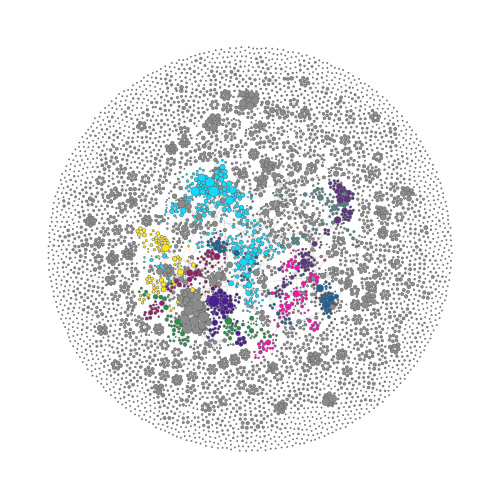

In [60]:
visualize(G_week4_copy)

### Explain

There are a lot of "chunks" in the intter part of the visualization. This implies that there exist groups of authors.

On the outer rim, there are lots of isolated nodes, here is the reason that so many groups were necessary (We did not succeed in coming up with 1425 unique colors). However, even in the grays, groups are clearly visible, so we don't think this takes away from the visualization.